#### Import necessary libraries

In [46]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
from seaborn import heatmap

#### Load the Dataset

In [47]:
DATASET_DIRECTORY = "./Datasets/"
DATASET_FILE_NAME = "Income.csv"
df = pd.read_csv(DATASET_DIRECTORY + DATASET_FILE_NAME)
TARGET = "income"

### Exploratory Data Analysis (EDA)

First of all, let's analyse the dataset using pandas methods.
1. DataFrame.info: Shows the type and number of non-NAN values for each column.

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   age         20 non-null     int64
 1   experience  20 non-null     int64
 2   income      20 non-null     int64
dtypes: int64(3)
memory usage: 612.0 bytes


2. DataFrame.head/tail: Shows n first/last rwos of the dataframe

In [49]:
numof_rows_to_display = 4
pd.concat([df.head(n=numof_rows_to_display), df.tail(n=numof_rows_to_display)])

,age,experience,income
0,25,1,30450
1,30,3,35670
2,47,2,31580
3,32,5,40130
16,58,17,63600
17,23,1,30870
18,44,9,44190
19,37,10,48700


3. DataFrame.describe: summarizes each numerical column using statistical metrics.

In [50]:
df.describe()

,age,experience,income
count,20.000000,20.000000,20.000000
mean,39.650000,6.200000,40735.500000
std,10.027725,4.124382,8439.797625
min,23.000000,1.000000,27840.000000
25%,31.500000,3.750000,35452.500000
50%,40.000000,5.000000,40190.000000
75%,47.000000,9.000000,45390.000000
max,58.000000,17.000000,63600.000000


Next step is to find the correlation between all pair of columns. Three different methods can be used, each with a different point of view:
- `Pearson`: measures the linear relationship between two variables.
- `Kendall`: measures the ordinal association between two variables.
- `Spearman`: measures the rank correlation between two variables.

Since we are going to implement a linear regression model, Pearson method is more suitable. 
The Pearson correlarion coefficient is calculated as follows:
$$ \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2 \sum_{i=1}^{n} (y_i - \bar{y})^2}} $$

The heatmap below indicates that the experience variable is strongly correlated with the target variable. It will probably lead to an accurate model.

<Axes: >

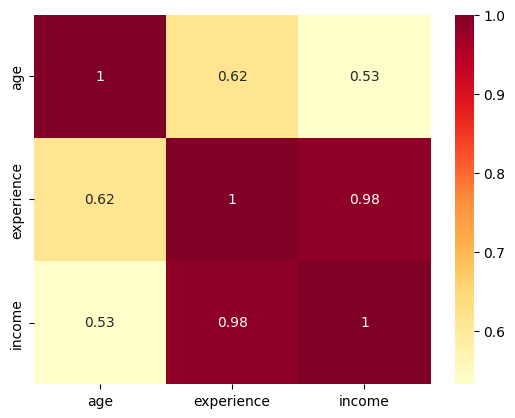

In [51]:
correlation_matrix = df.corr(method="pearson")
heatmap(correlation_matrix, annot=True, cmap="YlOrRd")

Here we plot all pair of variables based

In [52]:
cols = df.columns

fig = make_subplots(cols=len(cols), rows=len(cols), row_titles=[col for col in cols], column_titles=[col for col in cols])

for i in range(len(cols)):
    for j in range(len(cols)):
        if (i == j):
            plot = px.histogram(data_frame=df, x=cols[i], nbins=20)
        else:
            plot = px.scatter(data_frame=df, x=cols[i], y=cols[j])
        fig.add_trace(plot.data[0], col=i+1, row=j+1)
fig.update_layout(width=800, height=800)
fig.show()

### Visualizing Data

Here we use a 3D scatter plot to 
- strong linear relationship between experience and income.
- No visible relationship between age and income.
- In the 3 dimensional space (feature space), Almost all the data points lie on a plane.
- We know that a plane in a 3 dimensional space, shows a linear relationship of form $ ax + by + cz = d $ between the three dimensions.
- So it is possible to fit an accurate linear model on the 

In [53]:
fig = px.scatter_3d(data_frame=df, x="age", y="experience", z="income")
fig.show()

## Preprocessing
Preprocessing involves various steps.
- `Cleaning Data`: handle missing values, diplicate, noisy and outlier data.
- `Scaling and Normalizing Data`: Scale and normalize all features so that none of them would affect more than the others.
- `Encoding Categorical eatures`: To train ML models we need to have only numbers.

Only the second mentioned step is necessary in this simple task.

In [54]:
def report_duplicate_data(df):
    duplicated = df[df.duplicated()]
    if (len(duplicated)):
        print("There are", len(duplicated), "duplicated entries in the dataset")
        return duplicated
    else:
        print("No duplicate data")
        return None
report_duplicate_data(df=df)

No duplicate data


### Split Dataset into Train and Test

First we add a new column to represent the bias.

In [55]:
df['bias'] = 1
df = df[["bias"] + [col for col in df.columns if col != "bias"]]

In [56]:
train_size = 0.7
train_indices = np.random.choice(df.index, round(len(df) * train_size), replace=False)
df_train = df.loc[train_indices].reset_index(drop=True)
df_test = df.drop(train_indices).reset_index(drop=True)

### Normalization & Standardization
- *Normalization:* It is the process of scaling data into the range of zero to one.
### $$ \frac{x - min(x)}{max(x) - min(x)} $$
- *Standardization:* It results in a distribution that is centered around 0 ($ \mu = 0 $), with a standard deviation of 1 ($ \sigma = 1$ ).
### $$ \frac{x - \mu}{\sigma} $$
We need to scale all features in the same range in order to have a better regression models.

In [57]:
def normalize_data(x, min, max):
    if min == max:
        return x
    else:
        return  (x - min) / (max - min)

def standardize_data(x, mu, sigma):
    return (x - mu) / (sigma)

def denormalize_data(x, min, max):
    return ((x) * (max - min)) + min

minimums, maximums = {}, {}
for col in df.columns:
    # if col == TARGET:
    #     continue
    min = df_train[col].min()
    max = df_train[col].max()
    minimums[col] = min
    maximums[col] = max

    df_train[col] = normalize_data(df_train[col], min, max)
    df_test[col] = normalize_data(df_test[col], min, max)

In [58]:
features = [col for col in df_train.columns if col != TARGET]
X_train = df_train[features].to_numpy()
y_train = df_train[[TARGET]].to_numpy()
X_test = df_test[features].to_numpy()
y_test = df_test[[TARGET]].to_numpy()

### Evaluation Metric for Regression Models

$ MSE $: Shows the error of the model.
$$ MSE = \sum_{i=1}^n (\hat{y_i} - y_i)^2 $$
$ R^2 $: a statistical measure that determines the proportion of variance in the dependent variable that can be explained by the independent variable 
$$ R^2 =  1 - \frac{\sum_{i=1}^n (\hat{y_i} - y_i)^2}{\sum_{i=1}^n (\bar{y_i} - y_i)^2} $$

In [59]:
def calc_MSE(y_pred, y_true):
    n = len(y_true)
    SE = 0 # squared error
    for i in range(n):
        SE += (y_true[i] - y_pred[i]) ** 2
    MSE = SE / n
    return MSE

def calc_R2(y_pred, y_true):
    y_mean = np.mean(y_true)    
    # total sum of squares
    TSS = np.sum((y_true - y_mean) ** 2)
    # residual sum of squares
    RSS = np.sum((y_true - y_pred) ** 2)

    R2 = 1 - (RSS / TSS)
    return R2    

## Linear Regression using Gradient Descent

In a Linear Regression model, the target is predicted like this:
$$ \hat{y} = (\alpha_1 \times x_1) + (\alpha_2 \times x_2) + \cdots + (\alpha_p \times x_p) + bias $$
where $ X = {x_1, x_2, \cdots, x_p} $ is the vector of features, $ W = {\alpha_1, \alpha_2, \cdots, \alpha_p} $ is the vector of weights (parameters) and $ bias $ is the bias term.

Let's write it in the matrix form:
$$ \hat{y} = X^T W + bias $$
We can add the $ bias $ to $ W $ and push front 1 to the $ X $ vector.
$$ X = (1, x_1, x_2, \cdots, x_p) \text{ and } W = (bias, \alpha_1, \alpha_2, \cdots, \alpha_p) \quad \rightarrow \quad \hat{y} = X^T W $$

Given a set of training data points, we are going to find a linear model which best explain the training data points. Depends on how we define *best* the model would be different. We define best model as the model with least mean squared error (MSE). 

$$ MSE = \frac{1}{2} \sum_{i=1}^n (\hat{y} - y)^2 = \frac{1}{2} \sum_{i=1}^n (X^T W - y)^2 $$

$$ \text{Estimate } \alpha_i \to \hat{\alpha_i} $$
$$ \text{Estimate } y = \alpha_0 \times 1 + \alpha_1 \times x_1 + \cdots + \alpha_p \times x_p \quad \rightarrow \quad \hat{y} = y = \hat{\alpha_0} \times 1 + \hat{\alpha_1} \times x_1 + \cdots + \hat{\alpha_p} \times x_p $$
$$ \frac{\partial MSE}{\partial \alpha_i} = \frac{1}{n} \sum_{i}^n \frac{\partial(y_i - \hat{y}_i)}{\partial \alpha_i} \times (y_i - \hat{y}_i) = \frac{1}{n} \sum_{i}^n x_i \times (y_i - \hat{y}_i) $$
$$ \alpha_i = \alpha_i - \eta \times \frac{\partial(MSE)}{\partial \alpha_i} $$
Where $ \eta $ is the learning rate.

In [60]:
class MyLinearRegressionSGD:
    def __init__(self, learning_rate, iterations):
        self.lr = learning_rate
        self.numof_iterations = iterations
        self.weights = None
        self.mse_history = []

    def fit(self, X, y):
        numof_samples, numof_features = X.shape

        self.weights = np.zeros(numof_features)
        self.mse_history = []

        # Perform Gradient Descent
        for _ in range(self.numof_iterations):
            for _ in range(numof_samples):
                random_index = np.random.randint(numof_samples)
                random_X = X[random_index]
                random_y = y[random_index][0]

                y_pred = np.dot(random_X, self.weights)

                # Compute gradients
                dw = (1 / numof_samples) * np.dot(random_X, (y_pred - random_y))
                self.weights -= self.lr * dw

            self.mse_history.append(calc_MSE(y, self.predict(X=X)))

    def report_model(self, precision=3):
        reg = "y = "
        for i in range(len(self.weights)):
            if i == 0: # bias
                reg += f"{round(self.weights[i], precision)}"
            else: # weights
                if self.weights[i] > 0:
                    reg += f" + {round(self.weights[i], precision)} * x{i}"
                else :
                    reg += f" - {round(-self.weights[i], precision)} * x{i}"

        print(reg)
    
    def plot_error(self, num_intervals=20):
        errors = []
        interval_len = len(self.mse_history) // num_intervals
        for i in range(num_intervals):
            errors.append(np.mean(self.mse_history[i*interval_len: (i+1)*interval_len]))
        fig = px.line(errors)
        fig.show()

    def predict(self, X):
        return np.dot(X, self.weights)

In [61]:
SGD_model = MyLinearRegressionSGD(0.3, 1000)
SGD_model.fit(X=X_train, y=y_train)
SGD_model.report_model(precision=3)
SGD_model.plot_error(num_intervals=20)

y = 0.057 - 0.09 * x1 + 0.996 * x2


## Linear Regression using Normal Equations

$$ L(W) = \frac{1}{2} (y - XW)^T (y - XW) $$
Knowing below facts about matrix transposing, let's rewrite $ L(W) $:
- $ (A + B)^T = A^T + B^T $
- $ A^T B = B^T A $
- $ (AB)^T = B^T A^T $

$$ L(W) = \frac{1}{2} (y^T - (XW)^T)(y - XW) = \frac{1}{2} (y^T - W^T X^T)(y - XW) = \frac{1}{2} y^T y - \frac{1}{2} y^T XW - \frac{1}{2} W^T X^T y + \frac{1}{2} W^T X^T X W $$
$$ y^T X W = y^T (X W) = (X W)^T (y^T)^T = W^T X^T y \quad \rightarrow \quad L(W) = \frac{1}{2} y^T y - W^T X^T y + \frac{1}{2} W^T X^T X W $$ 
$$ \frac{\partial L(W)}{\partial W} = 0 - X^T y + 2\times \frac{1}{2} X^T X W = 0 \quad \rightarrow \quad X^T y = X^T X W $$
$$ X^T X W = X^T y \quad \rightarrow \quad (X^T X)^{-1} X^T X W = (X^T X)^{-1} X^T y \quad \rightarrow \quad W = (X^T X)^{-1} X^T y $$

In [62]:
class MyLinearRegressionNE:
    def __init__(self):
        self.weights = None
        
    def fit(self, X, y):
        numof_samples, numof_features = X.shape

        self.weights = np.zeros(numof_features)

    def fit(self, X, y):
        # Normal Equation: w = (X^T X)^-1 X^T y
        self.weights = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
        self.weights = self.weights.T[0]

    def report_model(self, precision=3):
        reg = "y = "
        for i in range(len(self.weights)):
            if i == 0: # bias
                reg += f"{round(self.weights[i], precision)}"
            else: # weights
                if self.weights[i] > 0:
                    reg += f" + {round(self.weights[i], precision)} * x{i}"
                else:
                    reg += f" - {round(-self.weights[i], precision)} * x{i}"

        print(reg)
    
    def plot_error(self, num_intervals=20):
        errors = []
        interval_len = len(self.mse_history) // num_intervals
        for i in range(num_intervals):
            errors.append(np.mean(self.mse_history[i*interval_len: (i+1)*interval_len]))
        fig = px.line(errors)
        fig.show()

    def predict(self, X):
        return np.dot(X, self.weights)

In [63]:
NE_model = MyLinearRegressionNE()
NE_model.fit(X_train, y_train)
NE_model.report_model(precision=3)

y = 0.072 - 0.088 * x1 + 0.995 * x2


## Compare Models

In [64]:
SGD_model.report_model()
NE_model.report_model()

y = 0.057 - 0.09 * x1 + 0.996 * x2
y = 0.072 - 0.088 * x1 + 0.995 * x2


In [65]:
SGD_pred_train = SGD_model.predict(X_train)
SGD_pred_test = SGD_model.predict(X_test)
NE_pred_train = NE_model.predict(X_train)
NE_pred_test = NE_model.predict(X_test)

y_train = y_train.T[0]
y_test = y_test.T[0]

SGD_MSE_train = calc_MSE(y_true=y_train, y_pred=SGD_pred_train)
SGD_MSE_test = calc_MSE(y_true=y_test, y_pred=SGD_pred_test)
NE_MSE_train = calc_MSE(y_true=y_train, y_pred=NE_pred_train)
NE_MSE_test = calc_MSE(y_true=y_test, y_pred=NE_pred_test)

SGD_R2_train = calc_R2(y_true=y_train, y_pred=SGD_pred_train)
SGD_R2_test = calc_R2(y_true=y_test, y_pred=SGD_pred_test)
NE_R2_train = calc_R2(y_true=y_train, y_pred=NE_pred_train)
NE_R2_test = calc_R2(y_true=y_test, y_pred=NE_pred_test)

In [66]:
data = {
    'MSE on train': [SGD_MSE_train, NE_MSE_train],
    'MSE on test': [SGD_MSE_test, NE_MSE_test],
    'R2 on train': [SGD_R2_train, NE_R2_train],
    'R2 on test': [SGD_R2_test, NE_R2_test]
}

result_df = pd.DataFrame(data, index=['SGD LR', 'NE LR'])
# result_df = result_df.apply(lambda x: x.round(4))
result_df


,MSE on train,MSE on test,R2 on train,R2 on test
SGD LR,0.001429,0.002135,0.976370,0.930777
NE LR,0.001209,0.001443,0.980008,0.953215


In [67]:
fig = make_subplots(rows=2, cols=2, row_titles=["SGD Model", "NE Model"], column_titles=["on Train set", "on Test set"])
fig.add_trace(px.scatter(x=SGD_pred_train, y=y_train).data[0], row=1, col=1)
fig.add_trace(px.scatter(x=SGD_pred_test, y=y_test).data[0], row=1, col=2)
fig.add_trace(px.scatter(x=NE_pred_train, y=y_train).data[0], row=2, col=1)
fig.add_trace(px.scatter(x=NE_pred_test, y=y_test).data[0], row=2, col=2)
fig.update_layout(width=800, height=800)
fig.show()